# Bayes hyperparameter search

## Set-up

In [2]:
import os
import itertools

import pandas as pd
import numpy as np
from keras.layers import \
    Dense, \
    LSTM, \
    BatchNormalization, \
    Dropout, \
    Activation
from keras import \
    initializers, \
    optimizers, \
    Sequential
from hyperopt import hp, fmin, rand, tpe, Trials
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [3]:
os.chdir('../..')

In [4]:
from src.models.utils import \
    _load_all_historical_data, \
    _map_season_string_to_ordered_numeric, \
    _generate_known_features_for_next_gw, \
    custom_train_test_split, \
    split_sequences, \
    _load_model_from_pickle
from src.models.constants import \
    COLUMNS_TO_DROP_FOR_TRAINING
from src.models.LSTM.make_predictions import LSTMPlayerPredictor
from src.visualisation.utils import plot_learning_curve

In [5]:
pd.options.display.max_columns = None

In [6]:
RANDOM_SEED = 42

## Load training data

In [7]:
def load_all_data():
    full_data = _load_all_historical_data()
    full_data.sort_values(['name', 'season', 'gw'], inplace=True)

    _map_season_string_to_ordered_numeric(full_data)
    _generate_known_features_for_next_gw(full_data)

    # Remove Brendan Galloway due to unexplained gap in gameweek data
    full_data = full_data[full_data['name'] != 'brendan_galloway']
    full_data.drop('ID', axis=1, inplace=True)

#     logging.info(f"Loaded historical data of shape {full_data.shape}")

    return full_data

In [8]:
all_data = load_all_data()

2020-06-04 00:23:59,759 - Loading raw historical FPL data
2020-06-04 00:23:59,968 - Creating season order column
2020-06-04 00:23:59,974 - Generating known features for next GW


In [9]:
print(all_data.shape)
all_data.head()

(67797, 68)


,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,minutes,own_goals,penalties_missed,penalties_saved,red_cards,gw,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,name,team_name,promoted_side,top_6_last_season,season,position_DEF,position_FWD,position_GK,position_MID,team_name_opponent,promoted_side_opponent,top_6_last_season_opponent,late_kickoff,early_kickoff,kickoff_month_Aug,kickoff_month_Sep,kickoff_month_Oct,kickoff_month_Nov,kickoff_month_Dec,kickoff_month_Jan,kickoff_month_Feb,kickoff_month_Mar,kickoff_month_Apr,kickoff_month_May,season_order,next_match_value,next_match_was_home,next_match_promoted_side_opponent,next_match_top_6_last_season_opponent,next_match_kickoff_month_Aug,next_match_kickoff_month_Sep,next_match_kickoff_month_Oct,next_match_kickoff_month_Nov,next_match_kickoff_month_Dec,next_match_kickoff_month_Jan,next_match_kickoff_month_Feb,next_match_kickoff_month_Mar,next_match_kickoff_month_Apr,next_match_kickoff_month_May,next_match_late_kickoff,next_match_early_kickoff
0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,1,0,14023,1,2,0.0,0,0,0,0,5.5,False,0,aaron_cresswell,West Ham United,0,0,2016-17,1,0,0,0,Chelsea,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,5.5,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,2,0,11531,0,1,0.0,0,-3002,79,3081,5.5,True,0,aaron_cresswell,West Ham United,0,0,2016-17,1,0,0,0,Bournemouth,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,5.4,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,3,0,9587,1,3,0.0,0,-2053,28,2081,5.4,False,0,aaron_cresswell,West Ham United,0,0,2016-17,1,0,0,0,Manchester City,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,5.4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,4,0,8427,4,2,0.0,0,-1221,45,1266,5.4,True,0,aaron_cresswell,West Ham United,0,0,2016-17,1,0,0,0,Watford,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,5.4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,5,0,7933,2,4,0.0,0,-520,29,549,5.4,False,0,aaron_cresswell,West Ham United,0,0,2016-17,1,0,0,0,West Bromwich Albion,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,5.4,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
all_data['season'].unique()

array(['2016-17', '2017-18', '2018-19'], dtype=object)

### Create target

In [11]:
all_data['total_points_plus1_gw'] = all_data.groupby(['name'])['total_points'].shift(-1)
all_data = all_data[~all_data['total_points_plus1_gw'].isnull()]  # drop nulls (last gw)

### Train/dev/test split

We now added a random_state parameter to `custom_train_test_split` to ensure consistent training sets

In [12]:
training_df, test_df = custom_train_test_split(all_data, random_state=RANDOM_SEED, rand_sample_prop=0.0027)

Proportion in test set: 0.09869880673982132
Test set size: (6584, 70)
Training set size: (60124, 70)


/Users/stevengeorge/opt/anaconda3/envs/fpl-analysis/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [13]:
training_df, dev_df = custom_train_test_split(training_df, random_state=RANDOM_SEED, rand_sample_prop=0.003)

Proportion in test set: 0.10238839731222141
Test set size: (6156, 70)
Training set size: (53968, 70)


In [14]:
print(f"Proportion training: {training_df.shape[0]/all_data.shape[0]}")
print(f"Proportion dev: {dev_df.shape[0]/all_data.shape[0]}")
print(f"Proportion test: {test_df.shape[0]/all_data.shape[0]}")

Proportion training: 0.8090184085866763
Proportion dev: 0.09228278467350243
Proportion test: 0.09869880673982132


We now get a close 80/10/10 split

## Current model performance

In [15]:
mms = _load_model_from_pickle('src/models/pickles/min_max_scalar_lstm_v4.pickle')
COLUMNS_TO_SCALE = _load_model_from_pickle('src/models/pickles/min_max_scalar_columns_v4.pickle')

### Filter out ineligible players

In [20]:
N_STEPS_IN = 5
N_STEPS_OUT = 5

In [21]:
def filter_eligible_players(training_subset_df):
    training_subset_df['total_number_of_gameweeks'] = training_subset_df.groupby(['name']).transform('count')['team_name']
    training_subset_df = training_subset_df[training_subset_df['total_number_of_gameweeks'] >= (N_STEPS_IN + N_STEPS_OUT - 1)]
    training_subset_df.drop('total_number_of_gameweeks', axis=1, inplace=True)
    
    return training_subset_df

In [22]:
training_df = filter_eligible_players(training_df)
dev_df = filter_eligible_players(dev_df)
test_df = filter_eligible_players(test_df)

In [23]:
def prepare_data_for_lstm(df):
    df = df.copy()    
    df[COLUMNS_TO_SCALE] = mms.transform(df[COLUMNS_TO_SCALE])

    X_list = []
    y_list = []

    for player in list(df['name'].unique()):
        player_df = df[df['name'] == player]
        player_df.drop(
            COLUMNS_TO_DROP_FOR_TRAINING,
            axis=1,
            inplace=True
        )
        X_player, y_player = split_sequences(
            df=player_df,
            target_column='total_points_plus1_gw',
            n_steps_in=N_STEPS_IN,
            n_steps_out=N_STEPS_OUT
        )
        X_list.append(X_player)
        y_list.append(y_player)

    X = np.concatenate(X_list, axis=0)
    y = np.concatenate(y_list, axis=0)
    print(X.shape)
    print(y.shape)
    
    return X, y

In [24]:
X_train, y_train = prepare_data_for_lstm(training_df)
X_dev, y_dev = prepare_data_for_lstm(dev_df)
X_test, y_test = prepare_data_for_lstm(test_df)

/Users/stevengeorge/opt/anaconda3/envs/fpl-analysis/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(45691, 5, 63)
(45691, 5)


/Users/stevengeorge/opt/anaconda3/envs/fpl-analysis/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(4995, 5, 63)
(4995, 5)


/Users/stevengeorge/opt/anaconda3/envs/fpl-analysis/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(5355, 5, 63)
(5355, 5)


### Pickle for easy load in Colab

In [44]:
import pickle

In [45]:
data = (X_train, y_train, X_dev, y_dev, X_test, y_test)

pickle.dump(data, open('src/models/pickles/bayes_data.pickle', 'wb'))

In [46]:
# X_train, y_train, X_dev, y_dev, X_test, y_test = pickle.load(open('src/models/pickles/bayes_data.pickle', 'rb'))

## Bayes hyperparameter search

In [41]:
SPACE = {
    'n_lstm_layers': hp.uniformint('n_lstm_layers', 1, 2),
    'lstm_units': hp.uniformint('lstm_units', 10, 200),
    'lstm_dropout': hp.quniform('lstm_dropout', low=0, high=0.5, q=0.01),
    'lstm_recurrent_dropout': hp.quniform('lstm_recurrent_dropout', low=0, high=0.5, q=0.01),
    'lstm_output_dropout': hp.quniform('lstm_output_dropout', low=0, high=0.5, q=0.01),
    'n_dense_layers': hp.uniformint('n_dense_layers', 0, 3),
    'dense_units': hp.uniformint('dense_units', 10, 200),
    'dense_dropout': hp.quniform('dense_dropout', low=0, high=0.5, q=0.01),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(0.5)),
    'batch_size': hp.uniformint('batch_size', 32, 1024)
}

INTEGER_PARAMS = ['n_lstm_layers', 'lstm_units', 'n_dense_layers', 'dense_units', 'batch_size']

In [26]:
from hyperopt.pyll.stochastic import sample

In [27]:
sample(SPACE)

{'batch_size': 100,
 'dense_dropout': 0.74,
 'dense_units': 23,
 'learning_rate': 0.019109565943996095,
 'lstm_dropout': 0.28,
 'lstm_output_dropout': 0.31,
 'lstm_recurrent_dropout': 0.98,
 'lstm_units': 45,
 'n_dense_layers': 3,
 'n_lstm_layers': 2}

In [28]:
def create_model(
    n_steps_in,
    n_steps_out,
    n_features,
    n_lstm_layers=1,
    lstm_units=50,
    lstm_dropout=0.0,
    lstm_recurrent_dropout=0.0,
    lstm_output_dropout=0.3,
    n_dense_layers=1,
    dense_units=50,
    dense_dropout=0.3
):
    model = Sequential(name='lstm_model')

    # LSTM layers
    if n_lstm_layers == 1:
        model.add(
            LSTM(
                units=lstm_units,
                dropout=lstm_dropout,
                recurrent_dropout=lstm_recurrent_dropout,
                input_shape=(n_steps_in, n_features),
                name='lstm_layer_1'
            )
        )
        model.add(
            Dropout(
                rate=lstm_output_dropout,
                name='lstm_layer_1_dropout'
            )
        )
    else:
        model.add(
            LSTM(
                units=lstm_units,
                dropout=lstm_dropout,
                recurrent_dropout=lstm_recurrent_dropout,
                return_sequences=True,
                input_shape=(n_steps_in, n_features),
                name='lstm_layer_1'
            )
        )
        for i in range(n_lstm_layers-1):
            model.add(
                LSTM(
                    units=lstm_units,
                    dropout=lstm_dropout,
                    recurrent_dropout=lstm_recurrent_dropout,
                    name=f'lstm_layer_{i+2}'
                )
            )
        model.add(
            Dropout(
                rate=lstm_output_dropout,
                name='lstm_multilayer_dropout'
            )
        )

    # Fully connected layers
    for i in range(n_dense_layers):
        model.add(Dense(dense_units, name=f'dense_layer_{i+1}'))
        model.add(BatchNormalization(name=f'dense_batch_norm_{i+1}'))
        model.add(Activation('relu', name=f'dense_activation_{i+1}'))
        model.add(Dropout(rate=dense_dropout, name=f'dense_dropout_{i+1}'))

    # Output layer
    model.add(Dense(
        n_steps_out, kernel_initializer=initializers.glorot_normal(), name='dense_output'
    ))

    return model

In [31]:
def objective(hyperparameters):
    # Hacky workaround for bug in package which saves integer hyperparameters as floats in the final dictionary. We
    # explicitly cast as integers to avoid errors.
    for hyper in INTEGER_PARAMS:
        try:
            as_int = int(hyperparameters[hyper])
            hyperparameters[hyper] = as_int
        except:
            continue

    # Extract keys not needed for model creation
    fitting_params = {}
    fitting_params['learning_rate'] = hyperparameters['learning_rate']
    fitting_params['batch_size'] = hyperparameters['batch_size']

    del hyperparameters['learning_rate'], hyperparameters['batch_size']

    # Create model
    lstm_model = create_model(n_steps_in=N_STEPS_IN, n_steps_out=N_STEPS_OUT, n_features=63, **hyperparameters)

    # Compile model
    optimizer = optimizers.Adam(learning_rate=fitting_params['learning_rate'])
    lstm_model.compile(loss='mse', optimizer=optimizer)

    # Fit model
    lstm_model.fit(X_train, y_train, batch_size=fitting_params['batch_size'], epochs=30, verbose=0)

    # Evaluate on dev set
    predictions = lstm_model.predict(X_dev)
    mse = mean_squared_error(y_dev, predictions)

    return mse  # Has to be a minimisation problem

## RUN BELOW CELL IN COLAB

In [109]:
%%time
bayes_trials = Trials()
best = fmin(fn=objective, space=SPACE, algo=tpe.suggest, max_evals=2, trials=bayes_trials, rstate=np.random.seed(RANDOM_SEED))

## Best Colab

In [83]:
colab_trials_dict = pickle.load(open('src/models/pickles/colab_trials_dict.pickle', 'rb'))

In [84]:
colab_trials_dict.keys()

dict_keys(['bayes_trials', 'best'])

In [85]:
bayes_trials = colab_trials_dict['bayes_trials']
best = colab_trials_dict['best']

In [86]:
best

{'batch_size': 527.0,
 'dense_dropout': 0.46,
 'dense_units': 25.0,
 'learning_rate': 0.0010974169408205815,
 'lstm_dropout': 0.02,
 'lstm_output_dropout': 0.03,
 'lstm_recurrent_dropout': 0.5,
 'lstm_units': 15.0,
 'n_dense_layers': 0.0,
 'n_lstm_layers': 1.0}

In [87]:
pd.DataFrame(bayes_trials.trials).shape

(300, 10)

In [88]:
hyperparams = best.copy()

In [89]:
fitting_params = {}
fitting_params['learning_rate'] = hyperparams['learning_rate']
fitting_params['batch_size'] = hyperparams['batch_size']

del hyperparams['learning_rate'], hyperparams['batch_size']

In [90]:
hyperparams

{'dense_dropout': 0.46,
 'dense_units': 25.0,
 'lstm_dropout': 0.02,
 'lstm_output_dropout': 0.03,
 'lstm_recurrent_dropout': 0.5,
 'lstm_units': 15.0,
 'n_dense_layers': 0.0,
 'n_lstm_layers': 1.0}

In [91]:
fitting_params

{'learning_rate': 0.0010974169408205815, 'batch_size': 527.0}

In [93]:
fitting_params['batch_size'] = int(fitting_params['batch_size'])

In [92]:
for hyper in INTEGER_PARAMS:
    try:
        as_int = int(hyperparams[hyper])
        hyperparams[hyper] = as_int
    except:
        continue

In [114]:
colab_model = create_model(n_steps_in=N_STEPS_IN, n_steps_out=N_STEPS_OUT, n_features=63, **hyperparams)

In [115]:
colab_model.summary()

Model: "lstm_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_layer_1 (LSTM)          (None, 15)                4740      
_________________________________________________________________
lstm_layer_1_dropout (Dropou (None, 15)                0         
_________________________________________________________________
dense_output (Dense)         (None, 5)                 80        
Total params: 4,820
Trainable params: 4,820
Non-trainable params: 0
_________________________________________________________________


In [116]:
# Compile model
optimizer = optimizers.Adam(learning_rate=fitting_params['learning_rate'])
colab_model.compile(loss='mse', optimizer=optimizer)

In [117]:
# Fit model
colab_model.fit(X_train, y_train, batch_size=fitting_params['batch_size'], epochs=30, validation_data=(X_dev, y_dev))

Train on 45691 samples, validate on 4995 samples
Epoch 1/30
45691/45691 [==============================] - 1s 31us/step - loss: 6.8791 - val_loss: 7.9823
Epoch 2/30
45691/45691 [==============================] - 1s 21us/step - loss: 5.5191 - val_loss: 6.8654
Epoch 3/30
45691/45691 [==============================] - 1s 21us/step - loss: 5.0325 - val_loss: 6.6698
Epoch 4/30
45691/45691 [==============================] - 1s 21us/step - loss: 4.9232 - val_loss: 6.5911
Epoch 5/30
45691/45691 [==============================] - 1s 21us/step - loss: 4.8683 - val_loss: 6.5530
Epoch 6/30
45691/45691 [==============================] - 1s 21us/step - loss: 4.8406 - val_loss: 6.5226
Epoch 7/30
45691/45691 [==============================] - 1s 21us/step - loss: 4.8230 - val_loss: 6.5011
Epoch 8/30
45691/45691 [==============================] - 1s 21us/step - loss: 4.8102 - val_loss: 6.4849
Epoch 9/30
45691/45691 [==============================] - 1s 21us/step - loss: 4.7996 - val_loss: 6.4802
Epoch 

Colab MSE was 6.41615761292976

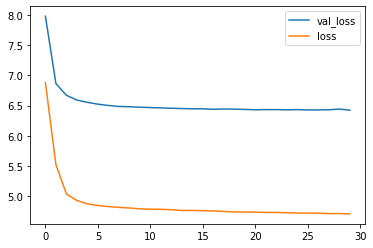

In [118]:
pd.DataFrame(colab_model.history.history).plot()

__Conclusions__

- The dev MSE of our current model is: 6.578626816417739
- After Bayes search the MSE was reduced to: 6.4226
- Interestingly the optimal architecture was very simple - a single LSTM layer with 15 units and no dense layer on top
- To get further improvements we can try adding more data and/or features